In [34]:
# !pip install mlxtend
# !pip install numpy scipy pandas scikit-learn


In [35]:
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
# from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [36]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\raduf\.cache\kagglehub\datasets\moltean\fruits\versions\11


In [37]:
img_size = (100, 100)  # Poți ajusta dimensiunea după necesitate
batch_size = 32

# Directorul de antrenare și testare
base_path = os.path.join(path, "fruits-360_dataset_100x100", "fruits-360")
train_dir = os.path.join(base_path, "Training")
test_dir = os.path.join(base_path, "Test")


In [38]:
# Generatoare de date
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Încărcarea imaginilor
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 70491 images belonging to 141 classes.
Found 23619 images belonging to 141 classes.


In [39]:
# def show_images(generator, class_names, num_images=10):
#     images, labels = next(generator)
#     plt.figure(figsize=(20, 5))
#     for i in range(num_images):
#         plt.subplot(2, 5, i+1)
#         plt.imshow(images[i])
#         label = np.argmax(labels[i])
#         plt.title(class_names[label])
#         plt.axis('off')
#     plt.show()


In [40]:
# # Obține numele claselor
# class_names = list(train_generator.class_indices.keys())

# # Afișează 10 imagini din setul de antrenare
# show_images(train_generator, class_names, num_images=10)


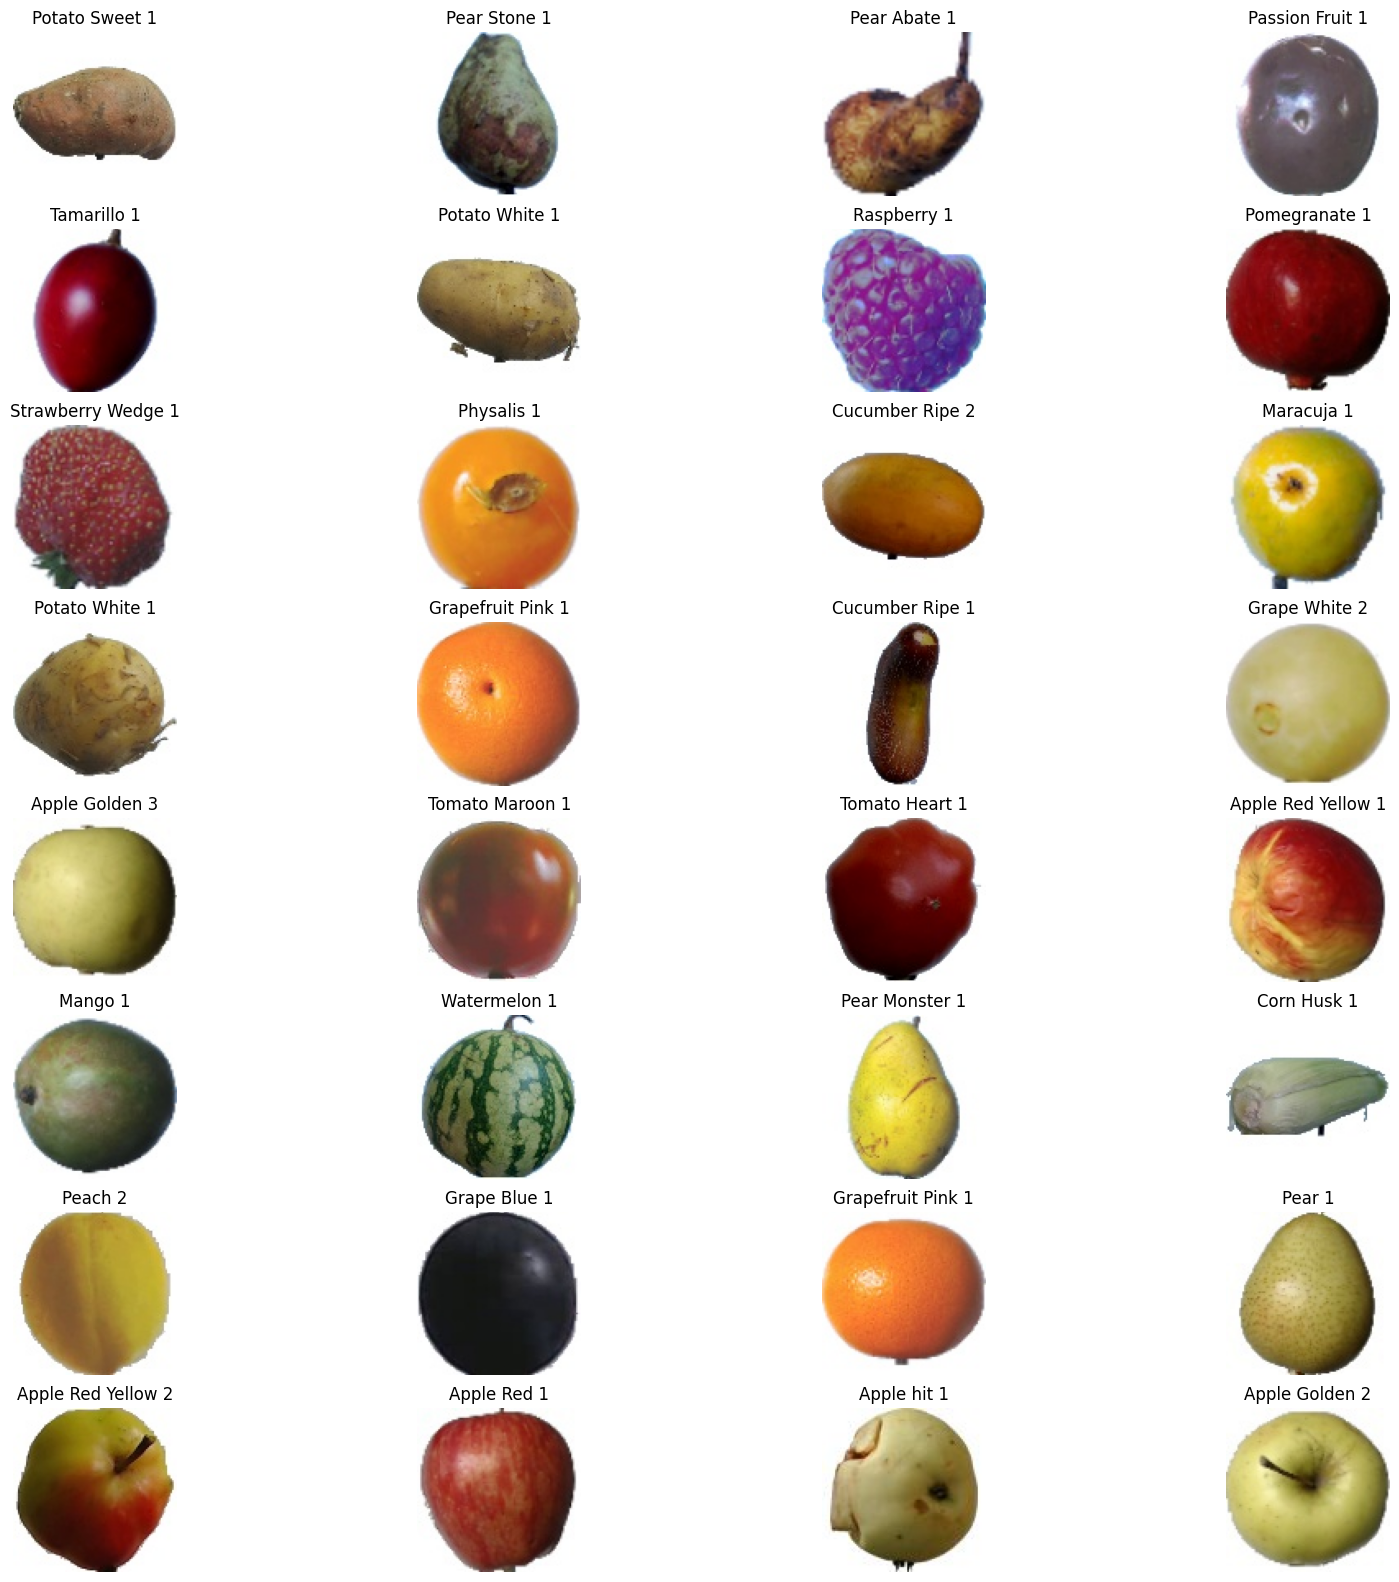

In [41]:
# Obține primul lot de imagini și etichete
images, labels = train_generator[0]
class_names = list(train_generator.class_indices.keys())
# Afișează toate imaginile din primul lot
plt.figure(figsize=(20, 20))
for i in range(len(images)):
    plt.subplot(8, 4, i+1)
    plt.imshow(images[i])
    label = np.argmax(labels[i])
    plt.title(class_names[label])
    plt.axis('off')
plt.show()


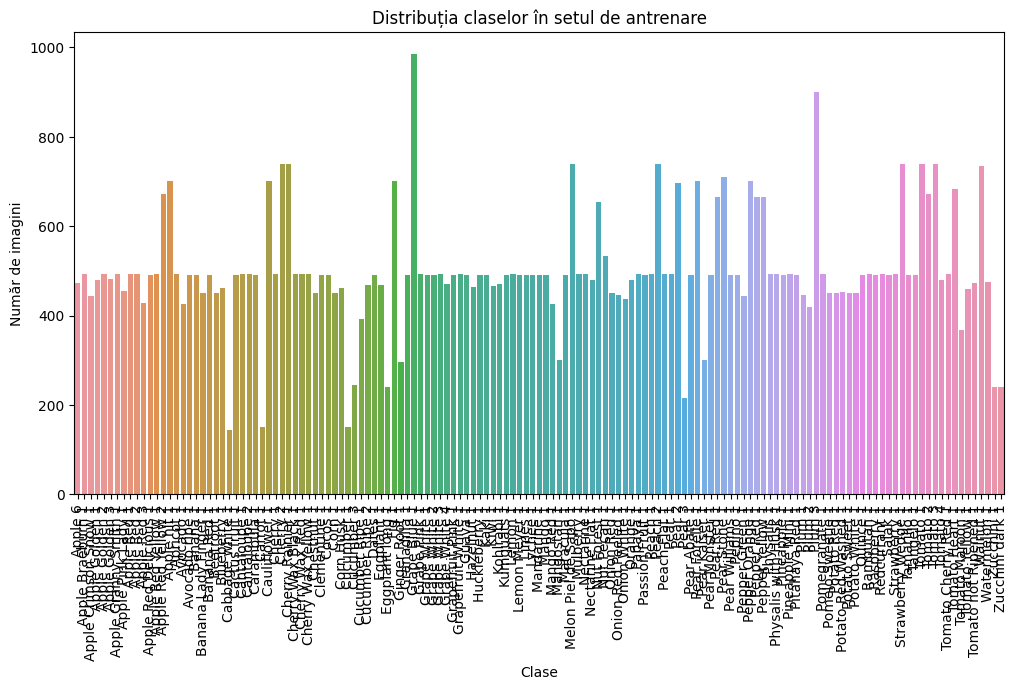

In [42]:
import seaborn as sns
import pandas as pd

# Obține etichetele claselor din generatorul de antrenare
labels = train_generator.classes
class_names = list(train_generator.class_indices.keys())

# Creare DataFrame pentru vizualizare
df = pd.DataFrame({'Label': labels})
class_distribution = df['Label'].value_counts().sort_index()

# Bar plot pentru distribuția claselor
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=class_distribution)
plt.xticks(rotation=90)
plt.title('Distribuția claselor în setul de antrenare')
plt.xlabel('Clase')
plt.ylabel('Număr de imagini')
plt.show()


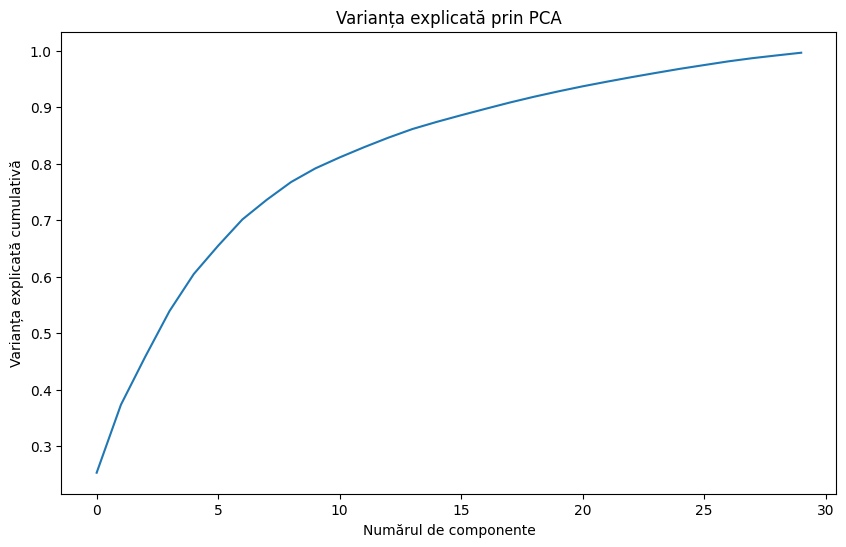

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Pregătirea datelor pentru PCA
X_train = train_generator[0][0].reshape(-1, 100*100*3)  # Transformarea imaginilor în vectori
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Aplicarea PCA
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_scaled)

# Vizualizarea varianței explicate
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Numărul de componente')
plt.ylabel('Varianța explicată cumulativă')
plt.title('Varianța explicată prin PCA')
plt.show()


In [44]:
from skimage.feature import hog
from skimage import color

# Funcție pentru a aplica HOG pe un set de imagini
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Conversie în grayscale pentru HOG
        gray_img = color.rgb2gray(img)
        features = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

# Extragem atributele HOG din datele de antrenare
X_train_hog = extract_hog_features(train_generator[0][0])

# Vizualizare dimensiune atribute
print(f"Dimensiunea atributelor HOG: {X_train_hog.shape}")


Dimensiunea atributelor HOG: (32, 4356)


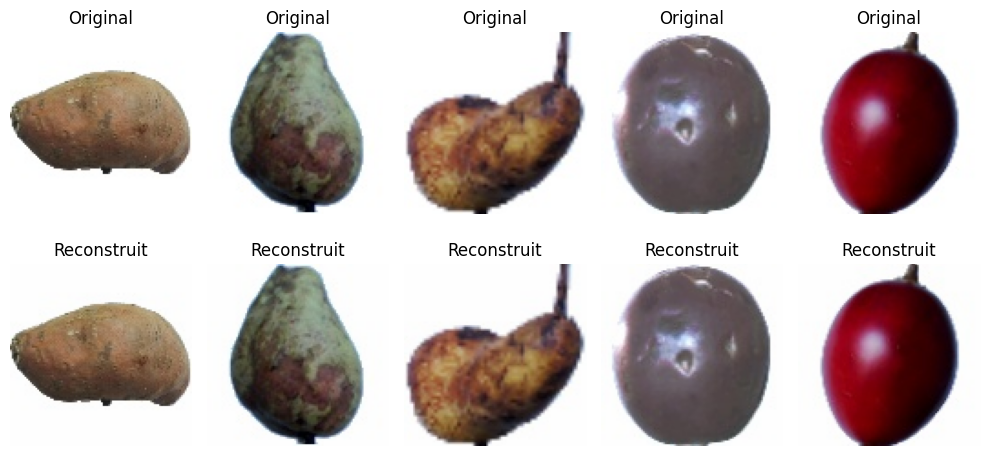

In [ ]:
# Reconstruirea imaginilor folosind PCA invers
X_reconstructed = pca.inverse_transform(X_train_pca)
X_reconstructed = scaler.inverse_transform(X_reconstructed)

# Vizualizarea imaginilor originale vs. reconstruite
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i].reshape(100, 100, 3))
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(2, 5, i + 6)
    plt.imshow(X_reconstructed[i].reshape(100, 100, 3).astype('uint8'))
    plt.title('Reconstruit')
    plt.axis('off')

plt.tight_layout()
plt.show()
